In [47]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [48]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [49]:
import numpy as np
import tensorflow as tf

In [50]:
import json
import sys

In [51]:
from tensorflow.keras.layers import Dense, Input, Layer
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [52]:
import matplotlib.pyplot as plt

In [53]:
from koopmanlib.dictionary import PsiNN
from koopmanlib.param_solver import (
    KoopmanBilinearDLSolver,
    KoopmanLinearDLSolver,
    KoopmanParametricDLSolver,
)
from koopmanlib.target import VanderPolMathieuTarget

In [54]:
config_file = "config_vdpm.json"

index = 1
with open(config_file, "r") as f:
    config = json.load(f)

data_path = config["data_settings"]["data_path"]
weights_path = config["nn_settings"]["weights_path"]

n_traj = config["data_settings"]["n_traj"]
traj_len = config["data_settings"]["traj_len"]
mu = config["data_settings"]["mu"][index]

n_psi_train = config["nn_settings"]["n_psi_train"]
dict_layer_size = config["nn_settings"]["dict_layer_size"]
K_layer_size = config["nn_settings"]["K_layer_size"][index]

In [55]:
dict_layer_size

[64]

In [56]:
print("mu", mu)
print("K_layer_size", K_layer_size)

mu 1
K_layer_size [16]


In [57]:
target_dim = 2
param_dim = 1

n_psi = 1 + target_dim + n_psi_train

In [58]:
n_psi

13

In [59]:
# Set parameters in the vdpm equation.
k1, k2, k4, w0 = 2, 2, 1, 1

In [60]:
vdp_mathieu = VanderPolMathieuTarget(
    mu=mu, dim=target_dim, param_dim=param_dim, k1=k1, k2=k2, k4=k4, w0=w0
)

In [61]:
dic_pk = PsiNN(layer_sizes=dict_layer_size, n_psi_train=n_psi_train)

In [62]:
from koopmanlib.K_structure import Model_ResNet_K_u_Layer_One

model_K_u = Model_ResNet_K_u_Layer_One(layer_sizes=K_layer_size, n_psi=n_psi, activation="tanh")

solver_pk = KoopmanParametricDLSolver(
    target_dim=target_dim, param_dim=param_dim, n_psi=n_psi, dic=dic_pk, model_K_u=model_K_u
)

model_pk, model_K_u_pred_pk = solver_pk.generate_model()

In [63]:
model_pk.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_18 (InputLayer)          [(None, 2)]          0           []                               
                                                                                                  
 tf.slice_6 (TFOpLambda)        (None, 1)            0           ['input_18[0][0]']               
                                                                                                  
 input_19 (InputLayer)          [(None, 2)]          0           []                               
                                                                                                  
 tf.ones_like_6 (TFOpLambda)    (None, 1)            0           ['tf.slice_6[0][0]']             
                                                                                            

In [64]:
model_pk.load_weights(os.path.join(weights_path, "model_pk_vdpm_mu_" + str(mu) + ".h5"))

In [65]:
# model_pk.get_layer('DicNN').trainable = False
# for layer in solver_pk.model_K_u.hidden_layers:
#     layer.trainable = False
# solver_pk.model_K_u.output_layer.trainable = True
# model_pk.load_weights(os.path.join(weights_path, 'train_dense_model_pk_vdpm_mu_'+str(mu)+'.h5'))

# Linear Model: Dynamics is $Az +Bu$

In [66]:
dic_linear = PsiNN(layer_sizes=dict_layer_size, n_psi_train=n_psi_train)

In [67]:
solver_linear = KoopmanLinearDLSolver(
    dic=dic_linear, target_dim=target_dim, param_dim=param_dim, n_psi=n_psi
)
model_linear, model_K_u_pred_linear = solver_linear.build_model()

In [68]:
model_linear.load_weights(os.path.join(weights_path, "model_linear_vdpm_mu_" + str(mu) + ".h5"))

# Bilinear Model: Dynamics is $Az + \sum_{i=1}^{N_{u}}B_{i}zu_{i}$

In [69]:
dic_bilinear = PsiNN(layer_sizes=dict_layer_size, n_psi_train=n_psi_train)

In [70]:
solver_bilinear = KoopmanBilinearDLSolver(
    dic=dic_bilinear, target_dim=target_dim, param_dim=param_dim, n_psi=n_psi
)
model_bilinear, model_K_u_pred_bilinear = solver_bilinear.build_model()

In [71]:
model_bilinear.load_weights(
    os.path.join(weights_path, "model_bilinear_vdpm_mu_" + str(mu) + ".h5")
)

In [72]:
model_K_u_pred_bilinear.summary()

Model: "K_u_bilinear_pred"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_27 (InputLayer)          [(None, 13)]         0           []                               
                                                                                                  
 input_26 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 tf.einsum_1 (TFOpLambda)       (1, None, 13)        0           ['input_27[0][0]',               
                                                                  'input_26[0][0]']               
                                                                                                  
 tf.__operators__.getitem_1 (Sl  (None, 13)          0           ['tf.einsum_1[0][

In [73]:
dict_data = np.load(
        os.path.join(data_path, "vdpm_data_mu_" + str(mu) + ".npy"), allow_pickle=True
    )

data_x = dict_data[()]["data_x"]
data_y = dict_data[()]["data_y"]
data_u = dict_data[()]["data_u"]

In [74]:
data_x.shape

(50000, 2)

<!-- # Train PK-NN using data generated from Bi-linear model
dict_data = np.load(
        os.path.join(data_path, "vdpm_data_mu_" + str(mu) + ".npy"), allow_pickle=True
    )

data_x = dict_data[()]["data_x"]
data_y = dict_data[()]["data_y"]
data_u = dict_data[()]["data_u"]

print("data_x.shape = ", data_x.shape)
data_y_bilinear = []
for data_x_single, data_u_single in zip(data_x, data_u):
    data_y_bilinear_single = solver_bilinear.compute_data_list(
            traj_len=2, data_x_init=data_x_single, data_u=data_u_single
        )
    data_y_bilinear.append(data_y_bilinear_single[-1])

data_y_bilinear = np.array(data_y_bilinear)
data_y_bilinear.shape
# PK-NN
dic_pk = PsiNN(layer_sizes=dict_layer_size, n_psi_train=n_psi_train)
from koopmanlib.K_structure import Model_K_u_Layer, Model_ResNet_K_u_Layer_One

model_K_u = Model_ResNet_K_u_Layer_One(layer_sizes=K_layer_size, n_psi=n_psi, activation="tanh")

solver_pk = KoopmanParametricDLSolver(
    target_dim=target_dim, param_dim=param_dim, n_psi=n_psi, dic=dic_pk, model_K_u=model_K_u
)

model_pk, model_K_u_pred_pk = solver_pk.generate_model()


model_pk.compile(optimizer=Adam(0.001), loss="mse")

lr_callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="loss",
    factor=0.1,
    patience=100,
    verbose=0,
    mode="auto",
    min_delta=1e-4,
    cooldown=0,
    min_lr=1e-6,
)

# Define the early stopping criteria
es_callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", min_delta=1e-12, patience=50, verbose=1, mode="auto"
)

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=os.path.join(weights_path, "model_pk_vdpm_mu_" + str(mu) + ".h5"),
    monitor="val_loss",
    save_best_only=True,
    save_weights_only=True,
    mode="min",
    save_freq="epoch",
)

from tqdm.keras import TqdmCallback
# Define the TqdmCallback for progress bar
tqdm_callback = TqdmCallback(verbose=1)

# Add early_stopping to the list of callbacks
callbacks = [lr_callback, checkpoint_callback, tqdm_callback]

zeros_data_y_train = tf.zeros_like(dic_pk(data_y_bilinear))


history = model_pk.fit(
    x=[data_x, data_y_bilinear, data_u],
    y=zeros_data_y_train,
    validation_split=0.2,
    epochs=1000,
    batch_size=200,
    callbacks=callbacks,
    verbose=0,
)
data_pk_pred_from_bilinear = model_pk([data_x, data_y_bilinear, data_u])
data_y_pk_fake = []
for data_x_single, data_u_single in zip(data_x, data_u):
    data_y_pk_fake_single = solver_pk.compute_data_list(
            traj_len=2, data_x_init=data_x_single, data_u=data_u_single
        )
    data_y_pk_fake.append(data_y_pk_fake_single[-1])

data_y_pk_fake = np.array(data_y_pk_fake)
data_y_pk_fake - data_y_bilinear
data_y_pk_fake - data_y -->

In [75]:


# # Train K(u) to be (A+Bu)
# psi_x_data = dic_bilinear(data_x)
# target = model_K_u_pred_bilinear([data_u, psi_x_data])
# inputs_u = Input(shape=(param_dim,))
# inputs_psi_x = Input(shape=(n_psi,))

# fake_psi = model_K_u_pred_pk([inputs_u, inputs_psi_x])

# test_K_model = Model(inputs=[inputs_u, inputs_psi_x], outputs=fake_psi)

# test_K_model.compile(optimizer=Adam(0.000001), loss="mse")
# test_K_model.fit(x=[data_u, psi_x_data], y=target, epochs=500, batch_size=200, verbose=1)
# dic_pk.set_weights(dic_bilinear.get_weights())



## Prediction

In [76]:
from koopmanlib.functions import *

## Calculate average value

In [77]:
np.random.seed(625)
n_test = 20
seed_x_list = np.random.randint(1, 300, size=(n_test,))
seed_param_list = np.random.randint(1, 300, size=(n_test,))
n_traj_test = 1
traj_len_test = 50

In [78]:
ratio_pk_list = []
ratio_linear_list = []
ratio_bilinear_list = []

In [79]:
data_pred_list_pk_group = []
data_pred_list_linear_group = []
data_pred_list_bilinear_group = []
data_true_group = []

In [80]:
for seed_x, seed_param in zip(seed_x_list, seed_param_list):
    vdp_mathieu_test = VanderPolMathieuTarget(
        mu=mu, dim=target_dim, param_dim=param_dim, k1=k1, k2=k2, k4=k4, w0=w0
    )

    data_x_test, data_u_test = vdp_mathieu_test.generate_init_data(
        n_traj=n_traj_test, traj_len=traj_len_test, seed_x=seed_x, seed_param=seed_param
    )
    data_x_init = tf.reshape(data_x_test[0], shape=(1, -1))
    data_true = data_x_test

    data_pred_list_pk = solver_pk.compute_data_list(traj_len_test, data_x_init, data_u_test)
    data_pred_list_linear = solver_linear.compute_data_list(
        traj_len=traj_len_test, data_x_init=data_x_init, data_u=data_u_test
    )
    data_pred_list_bilinear = solver_bilinear.compute_data_list(
        traj_len=traj_len_test, data_x_init=data_x_init, data_u=data_u_test
    )

    ratio_pk = compute_diff_ratio_one_traj(data_true, data_pred_list_pk)
    ratio_linear = compute_diff_ratio_one_traj(data_true, data_pred_list_linear)
    ratio_bilinear = compute_diff_ratio_one_traj(data_true, data_pred_list_bilinear)

    ratio_pk_list.append(ratio_pk)
    ratio_linear_list.append(ratio_linear)
    ratio_bilinear_list.append(ratio_bilinear)

    data_pred_list_pk_group.append(data_pred_list_pk)
    data_pred_list_linear_group.append(data_pred_list_linear)
    data_pred_list_bilinear_group.append(data_pred_list_bilinear)
    data_true_group.append(data_true)

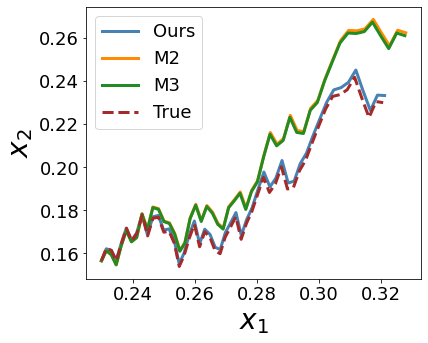

In [81]:
plt.figure(figsize=(6, 5))
plt.plot(
    data_pred_list_pk[:, 0], data_pred_list_pk[:, 1], label="Ours", color="steelblue", linewidth=3
)
plt.plot(
    data_pred_list_linear[:, 0],
    data_pred_list_linear[:, 1],
    label="M2",
    color="darkorange",
    linewidth=3,
)
plt.plot(
    data_pred_list_bilinear[:, 0],
    data_pred_list_bilinear[:, 1],
    label="M3",
    color="forestgreen",
    linewidth=3,
)
plt.plot(
    data_true[:, 0], data_true[:, 1], label="True", color="brown", linestyle="dashed", linewidth=3
)
plt.xlabel(r"$x_{1}$", fontsize=28)
plt.ylabel(r"$x_{2}$", fontsize=28)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(fontsize=18)

In [82]:
data_pred_list_pk_group = np.asarray(data_pred_list_pk_group)
data_pred_list_linear_group = np.asarray(data_pred_list_linear_group)
data_pred_list_bilinear_group = np.asarray(data_pred_list_bilinear_group)
data_true_group = np.asarray(data_true_group)

In [83]:
# for i in range(data_pred_list_pk_group.shape[0]):
#     plt.figure(figsize=(6, 5))
#     plt.plot(
#         data_pred_list_pk_group[i, :, 0],
#         data_pred_list_pk_group[i, :, 1],
#         label="Ours",
#         color="steelblue",
#         linewidth=3,
#     )
#     plt.plot(
#         data_pred_list_linear_group[i, :, 0],
#         data_pred_list_linear_group[i, :, 1],
#         label="M2",
#         color="darkorange",
#         linewidth=3,
#     )
#     plt.plot(
#         data_pred_list_bilinear_group[i, :, 0],
#         data_pred_list_bilinear_group[i, :, 1],
#         label="M3",
#         color="forestgreen",
#         linewidth=3,
#     )
#     plt.plot(
#         data_true_group[i, :, 0],
#         data_true_group[i, :, 1],
#         label="True",
#         color="brown",
#         linestyle="dashed",
#         linewidth=3,
#     )
#     plt.xlabel(r"$x_{1}$", fontsize=28)
#     plt.ylabel(r"$x_{2}$", fontsize=28)
#     plt.xticks(fontsize=18)
#     plt.yticks(fontsize=18)
#     plt.legend(fontsize=18)

In [84]:
ratio_pk_list = np.asarray(ratio_pk_list)
ratio_linear_list = np.asarray(ratio_linear_list)
ratio_bilinear_list = np.asarray(ratio_bilinear_list)

In [85]:
ratio_pk_list_mean = np.mean(ratio_pk_list, axis=0)
ratio_linear_list_mean = np.mean(ratio_linear_list, axis=0)
ratio_bilinear_list_mean = np.mean(ratio_bilinear_list, axis=0)

In [86]:
ratio_pk_list_median = np.median(ratio_pk_list, axis=0)
ratio_linear_list_median = np.median(ratio_linear_list, axis=0)
ratio_bilinear_list_median = np.median(ratio_bilinear_list, axis=0)

In [87]:
q_min = 0.35
q_max = 0.65

In [88]:
ratio_pk_list

array([[0.00000000e+00, 1.31962428e-04, 1.08827937e-04, 9.91088600e-05,
        2.61554294e-04, 2.80731825e-04, 4.14135100e-04, 6.12527547e-04,
        8.25067450e-04, 9.28264363e-04, 1.01812236e-03, 1.05924659e-03,
        1.10669471e-03, 1.19393000e-03, 1.23770206e-03, 1.25201295e-03,
        1.27871172e-03, 1.35124686e-03, 1.38994962e-03, 1.43291164e-03,
        1.51589408e-03, 1.52533800e-03, 1.54972764e-03, 1.59407589e-03,
        1.67162825e-03, 1.76792973e-03, 1.84692217e-03, 1.90764566e-03,
        1.97831917e-03, 2.07487946e-03, 2.13205986e-03, 2.19563986e-03,
        2.23552905e-03, 2.26090905e-03, 2.30075142e-03, 2.32176404e-03,
        2.30427728e-03, 2.27842234e-03, 2.24512050e-03, 2.21073924e-03,
        2.17837770e-03, 2.14832209e-03, 2.12030678e-03, 2.09295219e-03,
        2.06733164e-03, 2.04321471e-03, 2.02130381e-03, 2.00200145e-03,
        1.99551670e-03, 1.99626795e-03],
       [0.00000000e+00, 5.09456530e-04, 7.71953472e-04, 9.78891298e-04,
        1.01143382e-03,

In [89]:
ratio_pk_list_min = np.quantile(ratio_pk_list, q=q_min, axis=0)
ratio_linear_list_min = np.quantile(ratio_linear_list, q=q_min, axis=0)
ratio_bilinear_list_min = np.quantile(ratio_bilinear_list, q=q_min, axis=0)

In [90]:
ratio_pk_list_max = np.quantile(ratio_pk_list, q=q_max, axis=0)
ratio_linear_list_max = np.quantile(ratio_linear_list, q=q_max, axis=0)
ratio_bilinear_list_max = np.quantile(ratio_bilinear_list, q=q_max, axis=0)

In [91]:
x_axis = np.arange(0, traj_len_test, 1)

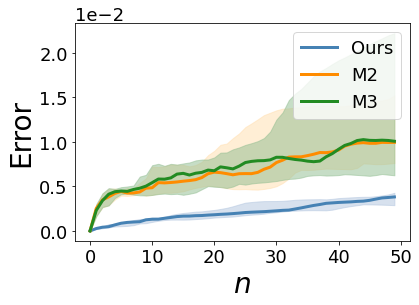

In [92]:
plt.figure(figsize=(6, 4))

plt.plot(ratio_pk_list_median, label="Ours", color="steelblue", linewidth=3)
plt.fill_between(x_axis, ratio_pk_list_min, ratio_pk_list_max, color="lightsteelblue", alpha=0.5)
plt.plot(ratio_linear_list_median, label="M2", color="darkorange", linewidth=3)
plt.fill_between(
    x_axis, ratio_linear_list_min, ratio_linear_list_max, color="navajowhite", alpha=0.5
)
plt.plot(ratio_bilinear_list_median, label="M3", color="forestgreen", linewidth=3)
plt.fill_between(
    x_axis, ratio_bilinear_list_min, ratio_bilinear_list_max, color="darkseagreen", alpha=0.5
)


plt.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
plt.gca().yaxis.get_offset_text().set_fontsize(18)

plt.xlabel(r"$n$", fontsize=28)
plt.ylabel("Error", fontsize=28)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(fontsize=18)

In [177]:
dict_mean = {
    "pk": ratio_pk_list_mean,
    "linear": ratio_linear_list_mean,
    "bilinear": ratio_bilinear_list_mean,
}

In [ ]:
# np.save(os.path.join(data_path, "ratio_list_dict_mu_" + str(mu) + "_mean.npy"), dict_mean)

# See the comparison
If you have tested on all $\mu: 0,1,2,3,4$, then you can run the following codes to see the comparison.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

mean_dict_mu_0 = np.load(
    os.path.join(data_path, "ratio_list_dict_mu_0_mean.npy"), allow_pickle=True
)
mean_dict_mu_1 = np.load(
    os.path.join(data_path, "ratio_list_dict_mu_1_mean.npy"), allow_pickle=True
)
mean_dict_mu_2 = np.load(
    os.path.join(data_path, "ratio_list_dict_mu_2_mean.npy"), allow_pickle=True
)
mean_dict_mu_3 = np.load(
    os.path.join(data_path, "ratio_list_dict_mu_3_mean.npy"), allow_pickle=True
)
mean_dict_mu_4 = np.load(
    os.path.join(data_path, "ratio_list_dict_mu_4_mean.npy"), allow_pickle=True
)


def extact_data(ratio_dict, ratio_name):
    ratio_pk = ratio_dict[()][ratio_name[0]].reshape((1, -1))
    ratio_linear = ratio_dict[()][ratio_name[1]].reshape((1, -1))
    ratio_bilinear = ratio_dict[()][ratio_name[2]].reshape((1, -1))
    return ratio_pk, ratio_linear, ratio_bilinear


mean_dict_list = [mean_dict_mu_0, mean_dict_mu_1, mean_dict_mu_2, mean_dict_mu_3, mean_dict_mu_4]

ratio_pk_list = []
ratio_linear_list = []
ratio_bilinear_list = []

ratio_name_list = ["pk", "linear", "bilinear"]


def concat_ratio_list(ratio_list):
    ratio_concat = np.concatenate(ratio_list, axis=0)
    ratio_concat = ratio_concat.T
    return ratio_concat


def concat_data(dict_list):
    pk_list = []
    linear_list = []
    bilinear_list = []

    for i in range(5):
        pk, linear, bilinear = extact_data(dict_list[i], ratio_name=ratio_name_list)
        pk_list.append(pk)
        linear_list.append(linear)
        bilinear_list.append(bilinear)

    pk_concat = concat_ratio_list(pk_list)
    linear_concat = concat_ratio_list(linear_list)
    bilinear_concat = concat_ratio_list(bilinear_list)

    return pk_concat, linear_concat, bilinear_concat


mean_pk, mean_linear, mean_bilinear = concat_data(mean_dict_list)

mean_linear_mean = np.mean(mean_linear, axis=0)
mean_bilinear_mean = np.mean(mean_bilinear, axis=0)
mean_pk_mean = np.mean(mean_pk, axis=0)

mu = [0, 1, 2, 3, 4]
mu_axis = list(range(len(mu)))


def plot_evaluate_vdpm(mu, mean, dict_plot):
    plt.plot(
        mu,
        mean,
        label=dict_plot["label"],
        marker=dict_plot["marker"],
        markersize=dict_plot["markersize"],
        color=dict_plot["color"],
        linestyle=dict_plot["linestyle"],
        linewidth=dict_plot["linewidth"],
    )


label_font = 24
ticks_font = 18
legend_font = 22


dict_plot_pk = {
    "label": "Ours",
    "marker": "*",
    "markersize": 10,
    "color": "steelblue",
    "linestyle": "-",
    "linewidth": 3,
}

dict_plot_linear = {
    "label": "M2",
    "marker": "s",
    "markersize": 10,
    "color": "darkorange",
    "linestyle": "-",
    "linewidth": 3,
}

dict_plot_bilinear = {
    "label": "M3",
    "marker": "o",
    "markersize": 10,
    "color": "forestgreen",
    "linestyle": "-",
    "linewidth": 3,
}

plt.figure(figsize=(15, 4))
plot_evaluate_vdpm(mu, mean_pk_mean, dict_plot=dict_plot_pk)
plot_evaluate_vdpm(mu, mean_linear_mean, dict_plot=dict_plot_linear)

plot_evaluate_vdpm(mu, mean_bilinear_mean, dict_plot=dict_plot_bilinear)

plt.xlabel(r"$\mu$", loc="right", fontsize=label_font)
plt.ylabel("Error", fontsize=label_font)
plt.xticks(mu_axis, mu, fontsize=ticks_font)
plt.yticks(fontsize=ticks_font)
plt.legend(fontsize=legend_font)